In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# W tym miejscu dataset musi byc gotowy
data_dir = ("./data")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# wskazenie ścieżki do danych uczących
train_dataset = image_dataset_from_directory(data_dir + "/train",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

# wskazenie ścieżki do danych testujacych
validation_dataset = image_dataset_from_directory(data_dir + "/test",
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 19717 files belonging to 2 classes.
Found 499 files belonging to 2 classes.


In [3]:
class_names = ["negative", "positive"]

In [4]:
# dane testujące dzielimy na 2 grupy:
# - pierwsza 80% (dane do validacji) jest wykorzystywana podczas uczenia, aby dostroić sieć
# - druga 20% (dane do testowania) nie są wykorzystywane podczas uczenia, dzięki temu możemy poprawnie zmierzyć dokładność
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 3


In [5]:
# to jest tylko wykorzystywane do poprawienia wydajności przy ładowaniu plikow z dysku
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
# aby poprawić wydajność sieci i zapobiedz overfitting, możemy nieco losowo zmodyfikować obraz np. odbicie pionowe, 
# dzięki temu nasz zbiór danych staje się nieco "większy"

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(-0.1, 0.1),
    #tf.keras.layers.experimental.preprocessing.RandomContrast(1.0), #moze wyjsc poza przedzial [0,1]
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
# sieć przyjmuje wartości z przedzialu [-1, 1] 
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

#tf.keras.applications.mobilenet_v2.preprocess_input(x)

In [9]:
# tworzymy model: sieć której użyjemy jest MobileNetV2 (bo jest szybka)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
# to konwertuje nasze obrazy w blocks of features

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
# blokujemy MobileNet aby jej nie uczyć (ona jest juz nauczona, my tylko będziemy uczyc ostatnia warstwe)
base_model.trainable = False

In [12]:
#mobile net na wyjściu daje wektor 1280, a to odbiera ten wektor

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
# dodaje ostatnia warstwe dostaniemy jedą wartość, wartość pozytywna odpowiada 1, a negatywna 0
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [14]:
# tworzenie modelu
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
# kompilacja modelu
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
#model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [17]:
#trenujemy tylko 2 wartości
len(model.trainable_variables)

2

In [18]:
initial_epochs = 10


In [19]:
# w train dataset mamy więcej danych negatywnych dlatego użytamy dodatkowych wag, aby obrazy pozytywne miały większy wpływ na uczenie
class_weight = {0: 0.75,   #negative
                1: 2.25}   #positive

{0: 0.75, 1: 2.25}


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
617/617 [==============================] - 318s 504ms/step - loss: 0.6596 - accuracy: 0.7603 - val_loss: 0.7281 - val_accuracy: 0.5533
Epoch 2/10
617/617 [==============================] - 306s 491ms/step - loss: 0.5100 - accuracy: 0.8358 - val_loss: 0.6675 - val_accuracy: 0.6129
Epoch 3/10
617/617 [==============================] - 314s 500ms/step - loss: 0.4575 - accuracy: 0.8566 - val_loss: 0.5570 - val_accuracy: 0.6774
Epoch 4/10
617/617 [==============================] - 305s 490ms/step - loss: 0.4231 - accuracy: 0.8685 - val_loss: 0.5454 - val_accuracy: 0.6973
Epoch 5/10
617/617 [==============================] - 310s 499ms/step - loss: 0.4082 - accuracy: 0.8733 - val_loss: 0.4793 - val_accuracy: 0.7295
Epoch 6/10
617/617 [==============================] - 307s 491ms/step - loss: 0.3787 - accuracy: 0.8863 - val_loss: 0.4759 - val_acc

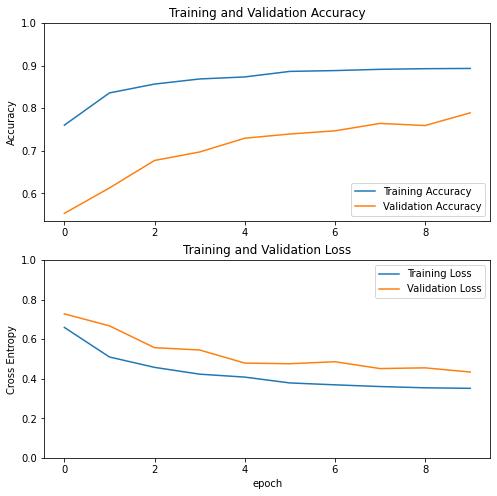

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [22]:
# będziemy teraz dostrajać sieć - uczyć kilka ostatnich warstw sieci mobileNet

base_model.trainable = True

In [23]:
# dostrajamy wszystko po:
fine_tune_at = 20

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [25]:
len(model.trainable_variables)

137

In [26]:
# dostrajanie
fine_tune_epochs = 8
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         class_weight=class_weight)

model.save("model.h5") # zapis wytrenowanego modelu

Epoch 10/18
617/617 [==============================] - 643s 1s/step - loss: 0.2875 - accuracy: 0.9106 - val_loss: 0.2631 - val_accuracy: 0.8834
Epoch 11/18
617/617 [==============================] - 658s 1s/step - loss: 0.1868 - accuracy: 0.9484 - val_loss: 0.2814 - val_accuracy: 0.8759
Epoch 12/18
617/617 [==============================] - 715s 1s/step - loss: 0.1493 - accuracy: 0.9606 - val_loss: 0.2989 - val_accuracy: 0.8685
Epoch 13/18
617/617 [==============================] - 745s 1s/step - loss: 0.1266 - accuracy: 0.9647 - val_loss: 0.5709 - val_accuracy: 0.7990
Epoch 14/18
617/617 [==============================] - 875s 1s/step - loss: 0.1168 - accuracy: 0.9692 - val_loss: 0.3715 - val_accuracy: 0.8734
Epoch 15/18
617/617 [==============================] - 808s 1s/step - loss: 0.1072 - accuracy: 0.9710 - val_loss: 0.2693 - val_accuracy: 0.8908
Epoch 16/18
617/617 [==============================] - 813s 1s/step - loss: 0.1022 - accuracy: 0.9719 - val_loss: 0.3380 - val_accuracy:

c:\users\ph025\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [29]:
#testujemy jeszcze dla zestawu testujacego (zestaw walidujacy moze źle testować, bo ma wpływ na uczenie)

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 11s 689ms/step - loss: 0.2161 - accuracy: 0.9167
Test accuracy : 0.9166666865348816


In [39]:
# serializacja history
import pickle
with open('1.history', 'wb') as history_file:
  pickle.dump(history.history, history_file)

with open('2.history', 'wb') as history_file:
  pickle.dump(history_fine.history, history_file)

In [40]:
# wczytanie z pliku
with open('1.history', 'rb') as history_file:
    des_history = pickle.load(history_file)
    #print(des_history.keys())
    
with open('2.history', 'rb') as history_file:
    des_history_fine = pickle.load(history_file)
    #print(des_history_fine.keys())
 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
